# Support vectors machine

Support Vector Machines: Discuss choice of kernel and parameters
used. Did you run any method to speed the building of the model? Report
number of supports of the selected machine and try to interpret why the
kernel selected and parameters selected for the final run give you the
best results for your dataset. Try also to inspect main supports of your
machine.

In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder


### Carregar les dades (pots substituir aquest pas amb la càrrega del teu conjunt de dades)

In [2]:
# canviar a preprocessed_encoded

csv = "preprocessed_encoded.csv"

# Read the CSV file
df = pd.read_csv(csv)

# # Fill missing values with the mean for continuous variables and the mode for categorical variables
# df.fillna(df.select_dtypes(include=[np.number]).mean(), inplace=True)
# for column in df.select_dtypes(include=['object']).columns:
#     df[column].fillna(df[column].mode()[0], inplace=True)

# # Encode categorical variables
# label_encoders = {}
# for column in df.select_dtypes(include=['object']).columns:
#     le = LabelEncoder()
#     df[column] = le.fit_transform(df[column])
#     label_encoders[column] = le

# Inspect the first few rows
df.head()

,wave,age,age_o,d_age,importance_same_race,importance_same_religion,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,...,field_social work,field_sociology,field_speech pathology,field_teaching of English,field_theory,field_working,decision_0,decision_1,decision_o_0,decision_o_1
0,1.0,21.0,27.0,6.0,2.0,4.0,35.0,20.0,20.0,20.0,...,0,0,0,0,0,0,0,1,1,0
1,1.0,21.0,22.0,1.0,2.0,4.0,60.0,0.0,0.0,40.0,...,0,0,0,0,0,0,0,1,1,0
2,1.0,21.0,22.0,1.0,2.0,4.0,19.0,18.0,19.0,18.0,...,0,0,0,0,0,0,0,1,0,1
3,1.0,21.0,23.0,2.0,2.0,4.0,30.0,5.0,15.0,40.0,...,0,0,0,0,0,0,0,1,0,1
4,1.0,21.0,24.0,3.0,2.0,4.0,30.0,10.0,20.0,10.0,...,0,0,0,0,0,0,0,1,0,1


In [7]:
old_df = pd.read_csv('preprocessed.csv')
y = old_df['match']

X = df

# Split the dataset in training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalization of the data starting from information of just the training set
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Apply the scaler to the test set
X_test = scaler.transform(X_test)

print(X.shape)
print(y.shape)

(8378, 336)
(8378,)


In [4]:
# Dividir les dades en conjunt d'entrenament i conjunt de prova
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Estandarditzar les dades
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

EXECUTAR PER KERNEL: RBF

In [8]:
# Definir el model SVM amb un kernel de base radial (RBF)
svc = SVC()

# Definir la cerca en graella per trobar els millors paràmetres
param_grid = {
    'C': [0.1, 1, 10, 100],
    # 'C': [0.1],
    'gamma': [1, 0.1, 0.01, 0.001],
    # 'gamma': [1],
    'kernel': ['rbf']
}

# Realitzar la cerca en graella amb validació creuada
grid = GridSearchCV(svc, param_grid, refit=True, verbose=2, cv=5)
grid.fit(X_train, y_train)

# Mostrar els millors paràmetres
print("Millors paràmetres trobats per GridSearchCV:")
print(grid.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  12.9s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  12.5s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  11.9s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  13.8s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  13.1s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  12.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  11.9s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  11.6s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  11.7s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=  11.3s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   5.9s
[CV] END ......................C=0.1, gamma=0.01

Informe de classificació:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      2106
           1       0.65      0.25      0.36       408

    accuracy                           0.86      2514
   macro avg       0.76      0.61      0.64      2514
weighted avg       0.83      0.86      0.83      2514

Precisió: 0.8564041368337311
Nombre de vectors de suport per classe: [1164  937]
Vectors de suport:
[[-0.73589624 -0.99218605 -0.65797732 ...  0.49104847  0.37661064
  -0.16537208]
 [-0.40092279  1.00787549 -0.65797732 ... -0.05734572 -0.10001498
  -0.16537208]
 [-0.06594933  1.00787549 -0.94174426 ...  0.49104847  0.37661064
  -0.16537208]
 ...
 [-1.74081662  1.00787549  0.47709042 ...  0.49104847  1.32986189
  -0.16537208]
 [-0.06594933  1.00787549  0.47709042 ...  0.49104847 -0.10001498
  -0.16537208]
 [ 0.43651086 -0.99218605  1.32839123 ...  1.03944265 -0.10001498
  -0.16537208]]


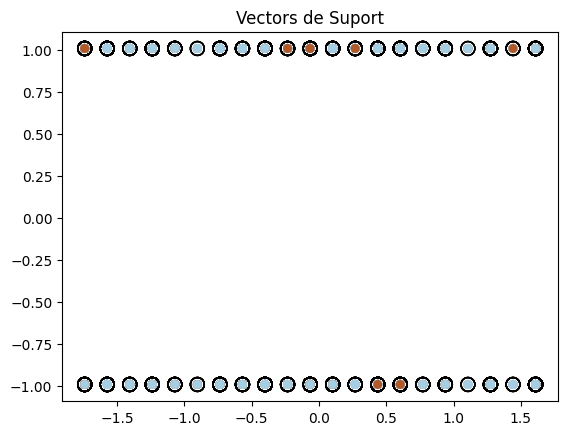

In [6]:
# Avaluar el model amb el conjunt de prova
y_pred = grid.predict(X_test)
print("Informe de classificació:")
print(classification_report(y_test, y_pred))
print("Precisió:", accuracy_score(y_test, y_pred))

# Nombre de vectors de suport
best_svc = grid.best_estimator_
print("Nombre de vectors de suport per classe:", best_svc.n_support_)

# Inspeccionar els vectors de suport principals
support_vectors = best_svc.support_vectors_
print("Vectors de suport:")
print(support_vectors)

# Opcional: Plotejar els vectors de suport (només per a conjunts de dades bidimensionals)
import matplotlib.pyplot as plt

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100, facecolors='none', edgecolors='k')
plt.title('Vectors de Suport')
plt.show()

EXECUTAR PER KERNEL: LINEAR

In [7]:
# Definir el model SVM amb un kernel de base radial (RBF)
svc = SVC()

# Definir la cerca en graella per trobar els millors paràmetres
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear']
}

# Realitzar la cerca en graella amb validació creuada
grid = GridSearchCV(svc, param_grid, refit=True, verbose=2, cv=5)
grid.fit(X_train, y_train)

# Mostrar els millors paràmetres
print("Millors paràmetres trobats per GridSearchCV:")
print(grid.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   1.4s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   1.3s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   1.3s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   1.3s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   1.4s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   1.3s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   1.3s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   1.3s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   1.3s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   1.4s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   1.4s
[CV] END ...................C=0.1, gamma=0.01, k

Informe de classificació:
              precision    recall  f1-score   support

           0       0.86      0.98      0.92      2106
           1       0.61      0.19      0.29       408

    accuracy                           0.85      2514
   macro avg       0.74      0.58      0.60      2514
weighted avg       0.82      0.85      0.81      2514

Precisió: 0.8488464598249801
Nombre de vectors de suport per classe: [984 953]
Vectors de suport:
[[-0.73589624 -0.99218605 -0.65797732 ...  0.49104847  0.37661064
  -0.16537208]
 [-0.40092279  1.00787549 -0.65797732 ... -0.05734572 -0.10001498
  -0.16537208]
 [ 1.60891796 -0.99218605 -1.2255112  ...  0.49104847  0.85323627
  -0.16537208]
 ...
 [-1.74081662  1.00787549  0.47709042 ...  0.49104847  1.32986189
  -0.16537208]
 [-0.06594933  1.00787549  0.47709042 ...  0.49104847 -0.10001498
  -0.16537208]
 [ 0.43651086 -0.99218605  1.32839123 ...  1.03944265 -0.10001498
  -0.16537208]]


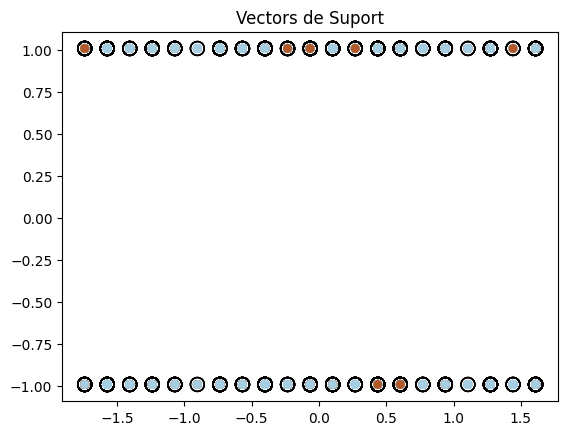

In [8]:
# Avaluar el model amb el conjunt de prova
y_pred = grid.predict(X_test)
print("Informe de classificació:")
print(classification_report(y_test, y_pred))
print("Precisió:", accuracy_score(y_test, y_pred))

# Nombre de vectors de suport
best_svc = grid.best_estimator_
print("Nombre de vectors de suport per classe:", best_svc.n_support_)

# Inspeccionar els vectors de suport principals
support_vectors = best_svc.support_vectors_
print("Vectors de suport:")
print(support_vectors)

# Opcional: Plotejar els vectors de suport (només per a conjunts de dades bidimensionals)
import matplotlib.pyplot as plt

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100, facecolors='none', edgecolors='k')
plt.title('Vectors de Suport')
plt.show()


EXECUTAR PER KERNEL: POLY

In [9]:
# Definir el model SVM amb un kernel de base radial (RBF)
svc = SVC()

# Definir la cerca en graella per trobar els millors paràmetres
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['poly']
}

# Realitzar la cerca en graella amb validació creuada
grid = GridSearchCV(svc, param_grid, refit=True, verbose=2, cv=5)
grid.fit(X_train, y_train)

# Mostrar els millors paràmetres
print("Millors paràmetres trobats per GridSearchCV:")
print(grid.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   1.3s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   1.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   1.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   1.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   1.1s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   1.1s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   1.1s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   1.0s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   1.1s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   1.1s
[CV] END .....................C=0.1, gamma=0.01, kernel=poly; total time=   0.7s
[CV] END .....................C=0.1, gamma=0.01,

Informe de classificació:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2106
           1       0.58      0.31      0.41       408

    accuracy                           0.85      2514
   macro avg       0.73      0.63      0.66      2514
weighted avg       0.83      0.85      0.83      2514

Precisió: 0.8516308671439936
Nombre de vectors de suport per classe: [1715  872]
Vectors de suport:
[[-0.73589624 -0.99218605 -0.65797732 ...  0.49104847  0.37661064
  -0.16537208]
 [ 0.60399759  1.00787549 -0.94174426 ... -0.05734572 -0.10001498
  -0.16537208]
 [ 1.60891796 -0.99218605 -1.2255112  ...  0.49104847  0.85323627
  -0.16537208]
 ...
 [-1.74081662  1.00787549  0.47709042 ...  0.49104847  1.32986189
  -0.16537208]
 [-0.06594933  1.00787549  0.47709042 ...  0.49104847 -0.10001498
  -0.16537208]
 [ 0.43651086 -0.99218605  1.32839123 ...  1.03944265 -0.10001498
  -0.16537208]]


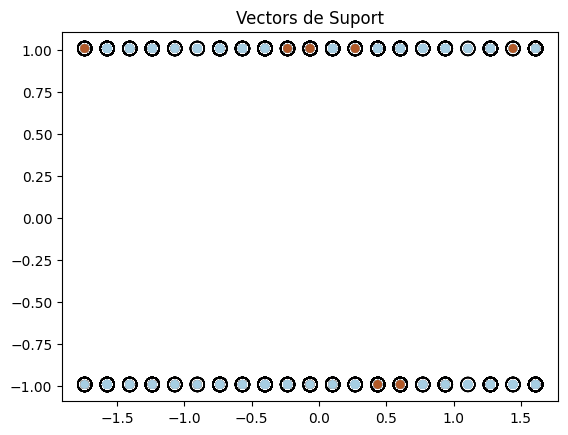

In [10]:
# Avaluar el model amb el conjunt de prova
y_pred = grid.predict(X_test)
print("Informe de classificació:")
print(classification_report(y_test, y_pred))
print("Precisió:", accuracy_score(y_test, y_pred))

# Nombre de vectors de suport
best_svc = grid.best_estimator_
print("Nombre de vectors de suport per classe:", best_svc.n_support_)

# Inspeccionar els vectors de suport principals
support_vectors = best_svc.support_vectors_
print("Vectors de suport:")
print(support_vectors)

# Opcional: Plotejar els vectors de suport (només per a conjunts de dades bidimensionals)
import matplotlib.pyplot as plt

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100, facecolors='none', edgecolors='k')
plt.title('Vectors de Suport')
plt.show()


EXECUTAR PER KERNEL: SIGMOID

In [11]:
# Definir el model SVM amb un kernel de base radial (RBF)
svc = SVC()

# Definir la cerca en graella per trobar els millors paràmetres
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['sigmoid']
}

# Realitzar la cerca en graella amb validació creuada
grid = GridSearchCV(svc, param_grid, refit=True, verbose=2, cv=5)
grid.fit(X_train, y_train)

# Mostrar els millors paràmetres
print("Millors paràmetres trobats per GridSearchCV:")
print(grid.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.8s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   1.0s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.8s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.7s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.7s
[CV] END ...................C=0.1, gamma=0.1, kernel=sigmoid; total time=   0.9s
[CV] END ...................C=0.1, gamma=0.1, kernel=sigmoid; total time=   0.8s
[CV] END ...................C=0.1, gamma=0.1, kernel=sigmoid; total time=   0.9s
[CV] END ...................C=0.1, gamma=0.1, kernel=sigmoid; total time=   0.8s
[CV] END ...................C=0.1, gamma=0.1, kernel=sigmoid; total time=   0.8s
[CV] END ..................C=0.1, gamma=0.01, kernel=sigmoid; total time=   0.8s
[CV] END ..................C=0.1, gamma=0.01, ke

Informe de classificació:
              precision    recall  f1-score   support

           0       0.86      0.98      0.91      2106
           1       0.60      0.18      0.28       408

    accuracy                           0.85      2514
   macro avg       0.73      0.58      0.60      2514
weighted avg       0.82      0.85      0.81      2514

Precisió: 0.8476531424025457
Nombre de vectors de suport per classe: [984 953]
Vectors de suport:
[[-0.73589624 -0.99218605 -0.65797732 ...  0.49104847  0.37661064
  -0.16537208]
 [-0.40092279  1.00787549 -0.65797732 ... -0.05734572 -0.10001498
  -0.16537208]
 [ 1.60891796 -0.99218605 -1.2255112  ...  0.49104847  0.85323627
  -0.16537208]
 ...
 [-1.74081662  1.00787549  0.47709042 ...  0.49104847  1.32986189
  -0.16537208]
 [-0.06594933  1.00787549  0.47709042 ...  0.49104847 -0.10001498
  -0.16537208]
 [ 0.43651086 -0.99218605  1.32839123 ...  1.03944265 -0.10001498
  -0.16537208]]


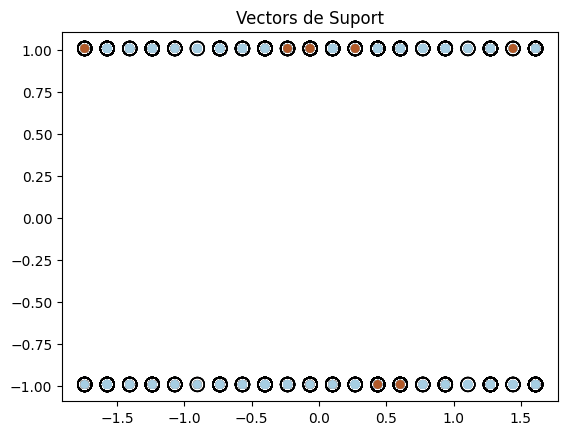

In [12]:
# Avaluar el model amb el conjunt de prova
y_pred = grid.predict(X_test)
print("Informe de classificació:")
print(classification_report(y_test, y_pred))
print("Precisió:", accuracy_score(y_test, y_pred))

# Nombre de vectors de suport
best_svc = grid.best_estimator_
print("Nombre de vectors de suport per classe:", best_svc.n_support_)

# Inspeccionar els vectors de suport principals
support_vectors = best_svc.support_vectors_
print("Vectors de suport:")
print(support_vectors)

# Opcional: Plotejar els vectors de suport (només per a conjunts de dades bidimensionals)
import matplotlib.pyplot as plt

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100, facecolors='none', edgecolors='k')
plt.title('Vectors de Suport')
plt.show()


TOT JUNT

In [13]:
# Definir el model SVM amb un kernel de base radial (RBF)
svc = SVC()

# Definir la cerca en graella per trobar els millors paràmetres
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
}

# Realitzar la cerca en graella amb validació creuada
grid = GridSearchCV(svc, param_grid, refit=True, verbose=2, cv=5)
grid.fit(X_train, y_train)

# Mostrar els millors paràmetres
print("Millors paràmetres trobats per GridSearchCV:")
print(grid.best_params_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   2.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.9s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.9s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   2.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.9s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.8s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.7s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.8s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.8s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.8s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   1.1s
[CV] END ........................C=0.1, gamma=1

Informe de classificació:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      2106
           1       0.00      0.00      0.00       408

    accuracy                           0.84      2514
   macro avg       0.42      0.50      0.46      2514
weighted avg       0.70      0.84      0.76      2514

Precisió: 0.837708830548926
Nombre de vectors de suport per classe: [4892  972]
Vectors de suport:
[[ 1.60891796  1.00787549 -0.65797732 ... -0.60573991 -1.05326622
  -0.16537208]
 [-0.40092279 -0.99218605 -0.65797732 ... -1.1541341  -0.10001498
  -0.16537208]
 [-0.73589624 -0.99218605 -0.65797732 ...  0.49104847  0.37661064
  -0.16537208]
 ...
 [-1.74081662  1.00787549  0.47709042 ...  0.49104847  1.32986189
  -0.16537208]
 [-0.06594933  1.00787549  0.47709042 ...  0.49104847 -0.10001498
  -0.16537208]
 [ 0.43651086 -0.99218605  1.32839123 ...  1.03944265 -0.10001498
  -0.16537208]]


/home/pau.cusco/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pau.cusco/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pau.cusco/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


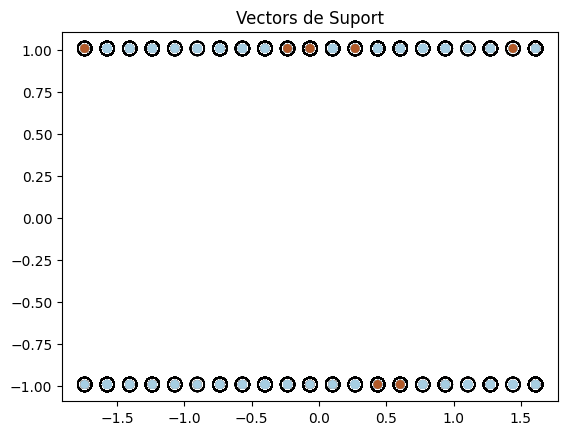

In [ ]:
# Avaluar el model amb el conjunt de prova
y_pred = grid.predict(X_test)
print("Informe de classificació:")
print(classification_report(y_test, y_pred))
print("Precisió:", accuracy_score(y_test, y_pred))

# Nombre de vectors de suport
best_svc = grid.best_estimator_
print("Nombre de vectors de suport per classe:", best_svc.n_support_)

# Inspeccionar els vectors de suport principals
support_vectors = best_svc.support_vectors_
print("Vectors de suport:")
print(support_vectors)

# Opcional: Plotejar els vectors de suport (només per a conjunts de dades bidimensionals)
import matplotlib.pyplot as plt

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100, facecolors='none', edgecolors='k')
plt.title('Vectors de Suport')
plt.show()
